# RLS递归最小二乘算法 - 代码实现与可视化

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
rcParams['axes.unicode_minus'] = False
np.random.seed(42)

## 1. RLS算法核心实现

In [2]:
def rls_filter(x, d, M, lam=0.99, delta=0.01):
    """
    RLS递归最小二乘算法
    参数:
        x: 输入信号
        d: 期望信号
        M: 滤波器阶数
        lam: 遗忘因子 (0 < lam <= 1)
        delta: 初始化参数 (P(0) = delta^{-1} * I)
    返回:
        y: 滤波器输出
        e: 误差信号
        w_history: 权值历史
    """
    N = len(x)
    w = np.zeros(M)  # 权值向量
    P = np.eye(M) / delta  # 逆相关矩阵
    
    y = np.zeros(N)
    e = np.zeros(N)
    w_history = [w.copy()]
    
    for n in range(M, N):
        x_vec = x[n-M:n][::-1]  # 输入向量 [x(n), x(n-1), ..., x(n-M+1)]
        
        # 1. 计算增益向量 k(n)
        Px = P @ x_vec
        denom = lam + x_vec @ Px
        k = Px / denom
        
        # 2. 计算先验误差
        y[n] = w @ x_vec
        e[n] = d[n] - y[n]
        
        # 3. 更新权值
        w = w + k * e[n]
        
        # 4. 更新逆相关矩阵
        P = (P - np.outer(k, x_vec @ P)) / lam
        
        w_history.append(w.copy())
    
    return y, e, np.array(w_history)

In [3]:
def lms_filter(x, d, M, mu):
    """LMS算法 (用于比较)"""
    N = len(x)
    w = np.zeros(M)
    y, e = np.zeros(N), np.zeros(N)
    w_history = [w.copy()]
    for n in range(M, N):
        x_vec = x[n-M:n][::-1]
        y[n] = w @ x_vec
        e[n] = d[n] - y[n]
        w = w + mu * e[n] * x_vec
        w_history.append(w.copy())
    return y, e, np.array(w_history)

## 2. 示例1: 系统辨识 - RLS vs LMS收敛速度比较

In [4]:
# 未知系统
w_true = np.array([0.5, -0.4, 0.3, -0.2, 0.1])
M = len(w_true)
N = 500

# 生成相关输入信号 (AR过程，使LMS收敛变慢)
a = 0.95  # AR系数
x = np.zeros(N)
for n in range(1, N):
    x[n] = a * x[n-1] + np.sqrt(1-a**2) * np.random.randn()

# 期望信号
d = np.convolve(x, w_true, mode='full')[:N] + 0.01 * np.random.randn(N)

# RLS
y_rls, e_rls, w_rls = rls_filter(x, d, M, lam=0.99)

# LMS (选择合适的步长)
mu = 0.01
y_lms, e_lms, w_lms = lms_filter(x, d, M, mu)

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

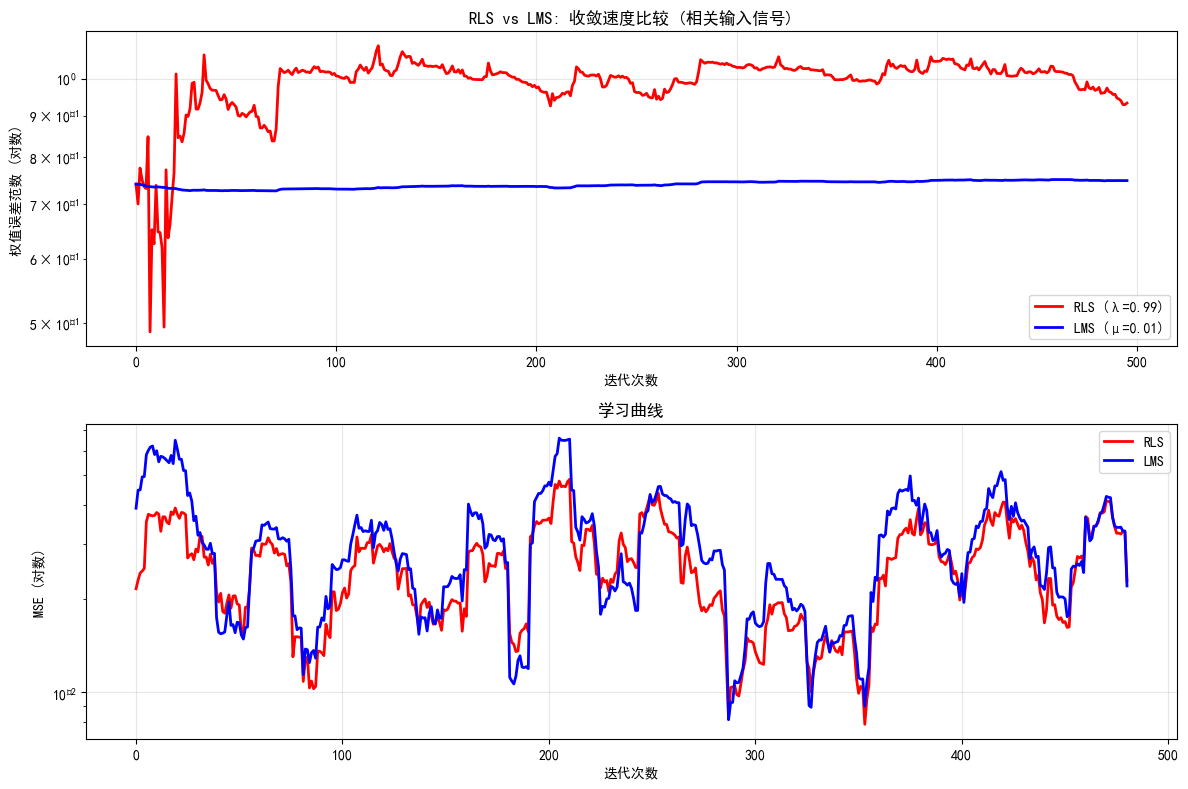

RLS最终权值误差: 0.932910
LMS最终权值误差: 0.749035

RLS收敛更快，尤其在输入信号高度相关时


In [5]:
# 计算权值误差
w_error_rls = [np.linalg.norm(w - w_true) for w in w_rls]
w_error_lms = [np.linalg.norm(w - w_true) for w in w_lms]

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# 权值误差收敛
ax1 = axes[0]
ax1.semilogy(w_error_rls, 'r-', linewidth=2, label='RLS (λ=0.99)')
ax1.semilogy(w_error_lms, 'b-', linewidth=2, label=f'LMS (μ={mu})')
ax1.set_xlabel('迭代次数')
ax1.set_ylabel('权值误差范数 (对数)')
ax1.set_title('RLS vs LMS: 收敛速度比较 (相关输入信号)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MSE学习曲线
ax2 = axes[1]
window = 20
mse_rls = np.convolve(e_rls**2, np.ones(window)/window, mode='valid')
mse_lms = np.convolve(e_lms**2, np.ones(window)/window, mode='valid')
ax2.semilogy(mse_rls, 'r-', linewidth=2, label='RLS')
ax2.semilogy(mse_lms, 'b-', linewidth=2, label='LMS')
ax2.set_xlabel('迭代次数')
ax2.set_ylabel('MSE (对数)')
ax2.set_title('学习曲线')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'RLS最终权值误差: {w_error_rls[-1]:.6f}')
print(f'LMS最终权值误差: {w_error_lms[-1]:.6f}')
print(f'\nRLS收敛更快，尤其在输入信号高度相关时')

## 3. 示例2: 遗忘因子λ的影响

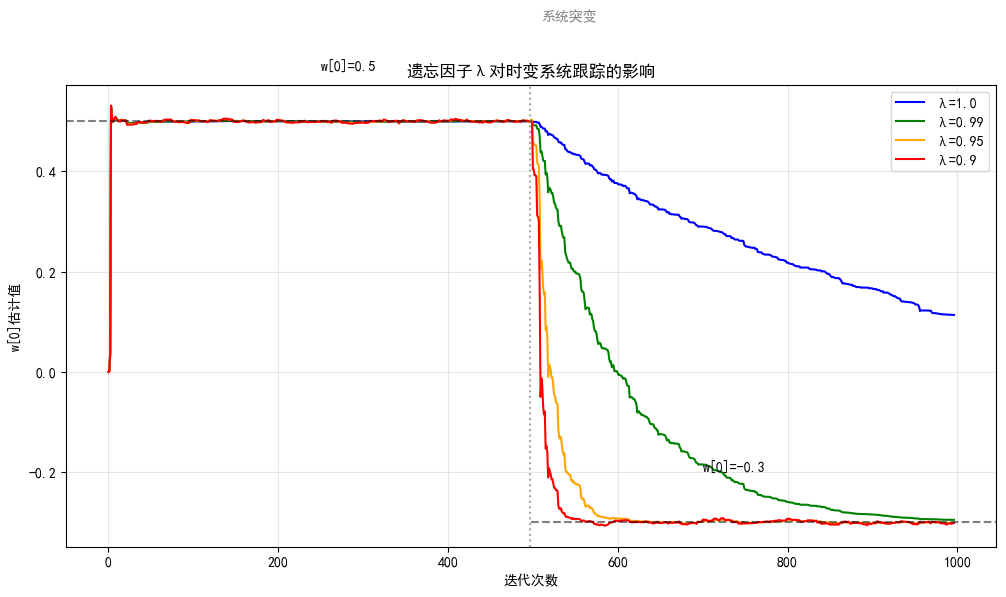

λ越小，跟踪越快，但稳态波动越大
λ=1时无法跟踪系统变化


In [6]:
# 时变系统跟踪
N = 1000
M = 4

# 输入信号
x = np.random.randn(N)

# 时变系统: 在n=500时系统参数突变
w_true1 = np.array([0.5, -0.3, 0.2, 0.1])
w_true2 = np.array([-0.3, 0.5, -0.1, 0.4])

d = np.zeros(N)
for n in range(M, N):
    x_vec = x[n-M:n][::-1]
    if n < 500:
        d[n] = w_true1 @ x_vec
    else:
        d[n] = w_true2 @ x_vec
d += 0.01 * np.random.randn(N)

# 不同遗忘因子
lambdas = [1.0, 0.99, 0.95, 0.9]
colors = ['blue', 'green', 'orange', 'red']

plt.figure(figsize=(12, 6))
for lam, color in zip(lambdas, colors):
    _, e, w_hist = rls_filter(x, d, M, lam=lam)
    # 计算对第一个系数的跟踪
    w0_track = [w[0] for w in w_hist]
    plt.plot(w0_track, color=color, linewidth=1.5, label=f'λ={lam}')

# 真实值
plt.axhline(y=w_true1[0], color='k', linestyle='--', alpha=0.5, xmax=0.5)
plt.axhline(y=w_true2[0], color='k', linestyle='--', alpha=0.5, xmin=0.5)
plt.axvline(x=500-M, color='gray', linestyle=':', alpha=0.7)
plt.text(250, 0.6, f'w[0]={w_true1[0]}', fontsize=10)
plt.text(700, -0.2, f'w[0]={w_true2[0]}', fontsize=10)
plt.text(510, 0.7, '系统突变', fontsize=10, color='gray')

plt.xlabel('迭代次数')
plt.ylabel('w[0]估计值')
plt.title('遗忘因子λ对时变系统跟踪的影响')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print('λ越小，跟踪越快，但稳态波动越大')
print('λ=1时无法跟踪系统变化')

## 4. 示例3: 信道均衡

In [7]:
# 信道均衡示例
N = 2000

# 发送的二进制符号
symbols = 2 * (np.random.randint(0, 2, N) - 0.5)  # {-1, +1}

# 信道冲激响应 (引入ISI)
channel = np.array([0.5, 1.0, 0.5])

# 接收信号 (经过信道 + 噪声)
received = np.convolve(symbols, channel, mode='full')[:N]
received += 0.1 * np.random.randn(N)

# 训练序列 (已知的发送符号，延迟补偿)
delay = 1  # 信道延迟
d = np.zeros(N)
d[delay:] = symbols[:-delay] if delay > 0 else symbols

# RLS均衡器
M = 11  # 均衡器长度
y_rls, e_rls, _ = rls_filter(received, d, M, lam=0.99)

# 判决
decisions = np.sign(y_rls)

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

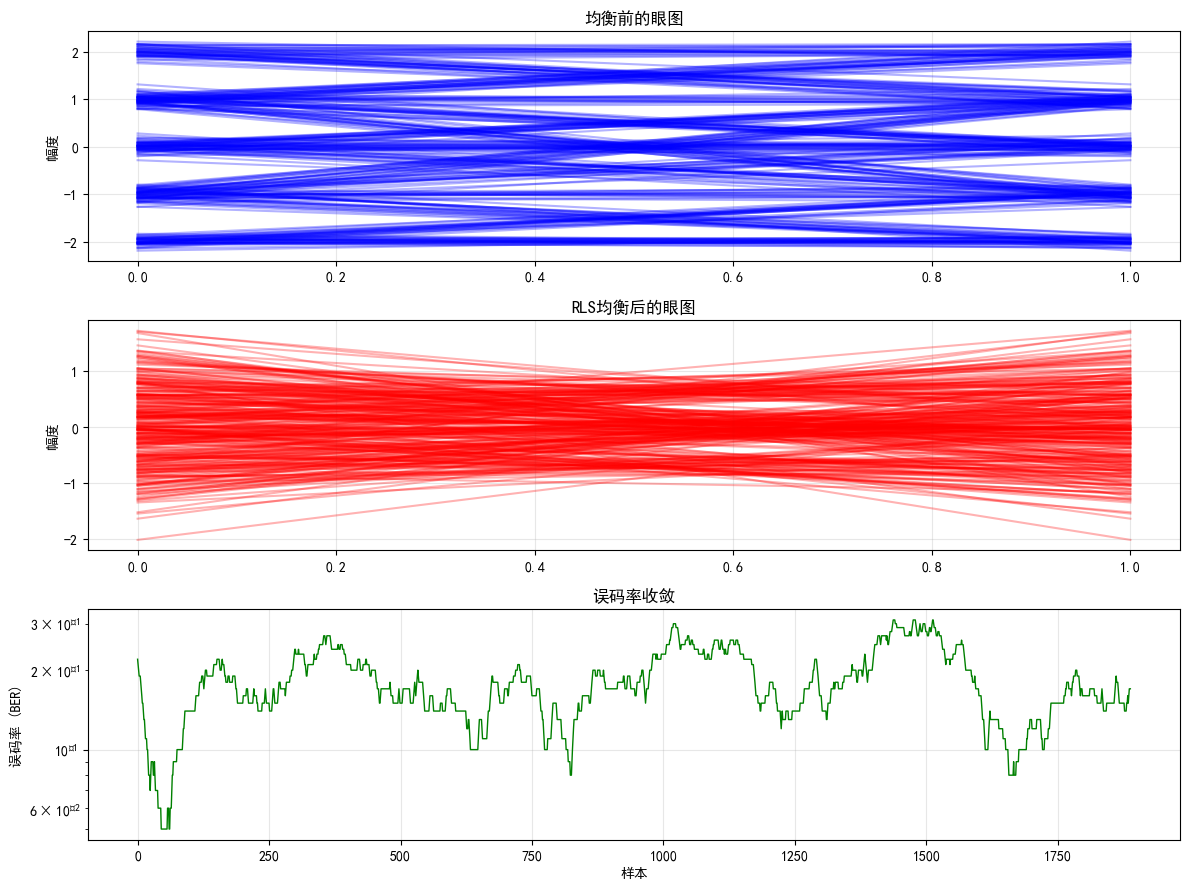

最终误码率: 0.1813


In [8]:
fig, axes = plt.subplots(3, 1, figsize=(12, 9))

# 眼图 - 均衡前
ax1 = axes[0]
samples_per_symbol = 1
for i in range(100, 400):
    ax1.plot([0, 1], [received[i], received[i+1]], 'b-', alpha=0.3)
ax1.set_title('均衡前的眼图')
ax1.set_ylabel('幅度')
ax1.grid(True, alpha=0.3)

# 眼图 - 均衡后
ax2 = axes[1]
for i in range(500, 800):
    ax2.plot([0, 1], [y_rls[i], y_rls[i+1]], 'r-', alpha=0.3)
ax2.set_title('RLS均衡后的眼图')
ax2.set_ylabel('幅度')
ax2.grid(True, alpha=0.3)

# 误码率随时间变化
ax3 = axes[2]
window = 100
ber = np.zeros(N - window)
for i in range(N - window):
    errors = np.sum(decisions[i:i+window] != d[i:i+window])
    ber[i] = errors / window
ax3.semilogy(ber[M:], 'g-', linewidth=1)
ax3.set_xlabel('样本')
ax3.set_ylabel('误码率 (BER)')
ax3.set_title('误码率收敛')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 计算最终BER
final_ber = np.mean(decisions[500:] != d[500:])
print(f'最终误码率: {final_ber:.4f}')

## 5. RLS增益向量分析

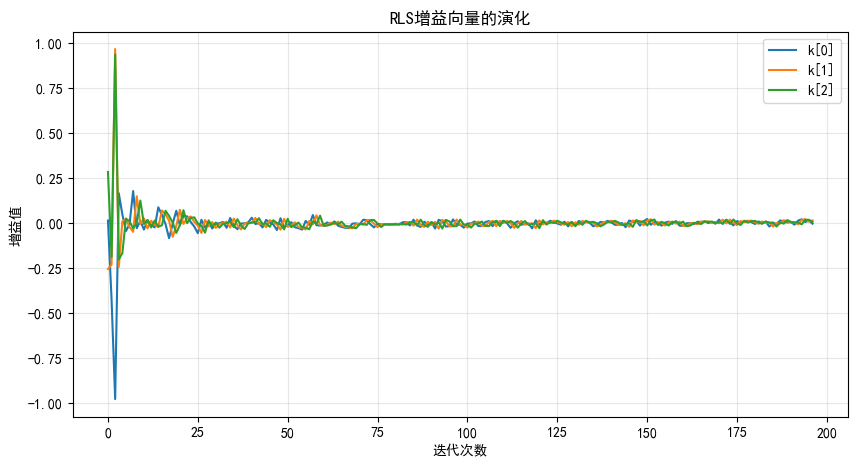

增益向量随着估计收敛而减小
这反映了对新观测数据的信任度降低


In [9]:
def rls_with_gain(x, d, M, lam=0.99, delta=0.01):
    """RLS算法，返回增益向量历史"""
    N = len(x)
    w = np.zeros(M)
    P = np.eye(M) / delta
    y, e = np.zeros(N), np.zeros(N)
    k_history = []
    
    for n in range(M, N):
        x_vec = x[n-M:n][::-1]
        Px = P @ x_vec
        denom = lam + x_vec @ Px
        k = Px / denom
        k_history.append(k.copy())
        
        y[n] = w @ x_vec
        e[n] = d[n] - y[n]
        w = w + k * e[n]
        P = (P - np.outer(k, x_vec @ P)) / lam
    
    return y, e, np.array(k_history)

# 运行并分析增益
w_true = np.array([0.5, -0.3, 0.2])
M = len(w_true)
N = 200
x = np.random.randn(N)
d = np.convolve(x, w_true, mode='full')[:N] + 0.01 * np.random.randn(N)

_, _, k_hist = rls_with_gain(x, d, M, lam=0.99)

plt.figure(figsize=(10, 5))
for i in range(M):
    plt.plot(k_hist[:, i], linewidth=1.5, label=f'k[{i}]')
plt.xlabel('迭代次数')
plt.ylabel('增益值')
plt.title('RLS增益向量的演化')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print('增益向量随着估计收敛而减小')
print('这反映了对新观测数据的信任度降低')

## 6. 总结\n\n### RLS算法特点:\n- 收敛速度快，与输入信号相关性无关\n- 计算复杂度O(M²)，比LMS高\n- 遗忘因子λ控制对历史数据的记忆\n- 适合跟踪时变系统\n\n### 参数选择建议:\n- λ=1: 平稳系统\n- λ=0.95~0.99: 缓慢时变系统\n- λ<0.95: 快速时变系统\n- δ: 通常取0.01~1，影响初始收敛